In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandasql as pdsql
import json
import gc # Garbage collector

### Load Schema Mappings

In [26]:
# Load schema mappings
with open('../data/schema/data_mapping_2019.json', 'r', encoding='utf-8') as f:
    schema_2019 = json.load(f)
with open('../data/schema/data_mapping_2013.json', 'r', encoding='utf-8') as f:
    schema_2013 = json.load(f)

# Create a mapping of column names to descriptions
column_descriptions = {}
for item in schema_2019 + schema_2013:
    if item['key'] and item['description']:
        column_descriptions[item['key']] = item['description']

# Function to get column description
def get_column_description(col_name):
    return column_descriptions.get(col_name, f"No description available for {col_name}")

### Set style for plots

In [27]:
plt.style.use('seaborn-v0_8')  # Updated to use valid style name
sns.set_theme()  # Using seaborn's default theme

### Read the data

In [28]:
df = pd.read_parquet("..\data\staged\PNS_union.parquet")
print(f"Total records: {len(df)}")

Total records: 251250


### Basic data information

In [ ]:
print("Basic Data Information:")
print(df.info())

### Check for missing values

In [32]:
print("Missing Values Analysis:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage,
    'Description': [get_column_description(col) for col in df.columns]
})
# Show only columns with missing values, sorted by percentage
print(missing_data[missing_data['Missing Values'] > 0].sort_values('Percentage', ascending=False))

Missing Values Analysis:
         Missing Values  Percentage  \
R00101           106310   42.312438   
S065             106310   42.312438   
Y002             106310   42.312438   
H001             106310   42.312438   
H003             106310   42.312438   
W001             106310   42.312438   
P00102           106310   42.312438   
P00103           106310   42.312438   
P00104           106310   42.312438   
P00402           106310   42.312438   
P00403           106310   42.312438   
P00404           106310   42.312438   
P00901           106310   42.312438   
P01101           106310   42.312438   
J00101           106310   42.312438   
J01101           106310   42.312438   
J01502           106310   42.312438   
J02702           106310   42.312438   
M01601           106310   42.312438   
N00101           106310   42.312438   
Q00201           106310   42.312438   
Q03001           106310   42.312438   
Q06306           106310   42.312438   
Q09301           106310   42.312438   


### Target variable analysis

In [33]:
# R011 is the endometriosis indicator according to the schema
has_endometriosis = df["R011"] == "3"

print("Endometriosis Distribution:")
endometriosis_counts = len(df[has_endometriosis])
print(f"Total cases: {endometriosis_counts}")
print(f"Prevalence Rate: {(endometriosis_counts / len(df)) * 100:.2f}%")

# Print the description of R011 from schema
print(f"Variable Description: {get_column_description('R011')}")

Endometriosis Distribution:
Total cases: 294
Prevalence Rate: 0.12%
Variable Description: Segundo o médico, qual o motivo da retirada do útero? 


### Demographic Analysis

#### Age distribution

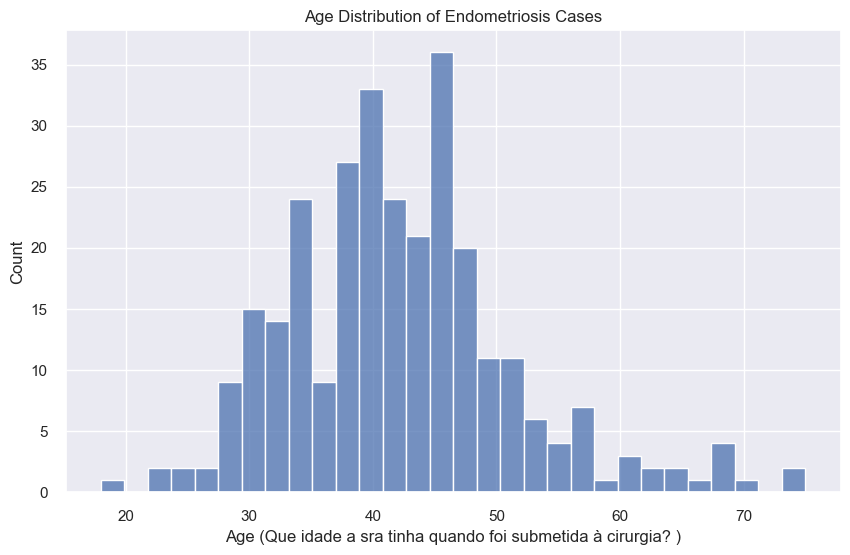

Age Statistics for Endometriosis Cases:
count    294.000000
mean      42.204082
std        9.165851
min       18.000000
25%       36.000000
50%       42.000000
75%       47.000000
max       75.000000
Name: R012, dtype: float64


In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df[has_endometriosis], x='R012', bins=30)
plt.title('Age Distribution of Endometriosis Cases')
plt.xlabel(f'Age ({get_column_description("R012")})')
plt.ylabel('Count')
plt.show()

# Basic statistics for age
age_stats = df[has_endometriosis]['R012'].describe()
print("Age Statistics for Endometriosis Cases:")
print(age_stats)

#### Additional Demographics Analysis

##### Analyze chronic conditions (Q series variables)

In [35]:
# Load descriptions_2019.json
with open('../data/schema/descriptions_2019.json', 'r', encoding='utf-8') as f:
    descriptions_2019 = json.load(f)


In [36]:
print("Chronic Conditions Analysis:")
chronic_conditions = ['Q00201', 'Q03001', 'Q060', 'Q06306', 'Q068', 'Q074', 'Q079', 'Q084', 'Q088', 'Q092', 'Q11006', 'Q11604', 'Q120', 'Q124', 'Q128']

print(chronic_conditions)

Chronic Conditions Analysis:
['Q00201', 'Q03001', 'Q060', 'Q06306', 'Q068', 'Q074', 'Q079', 'Q084', 'Q088', 'Q092', 'Q11006', 'Q11604', 'Q120', 'Q124', 'Q128']



Prevalence of Chronic Conditions:
        Endometriosis Group (%)  Control Group (%)  Difference (%)
Q00201                45.698925           9.935477       35.763448
Q084                  37.074830           7.055022       30.019808
Q060                  33.673469           5.461914       28.211556
Q092                  25.850340           3.848882       22.001458
Q079                  22.789116           3.392627       19.396489
Q03001                18.279570           3.079708       15.199862
Q120                   8.163265           0.822853        7.340412
Q06306                 9.139785           1.838291        7.301494
Q074                   7.142857           1.796729        5.346128
Q068                   3.061224           0.629592        2.431632
Q124                   2.721088           0.476179        2.244909
Q11006                      NaN                NaN             NaN
Q11604                      NaN           0.494632             NaN
Q128                       

<Figure size 1200x800 with 0 Axes>

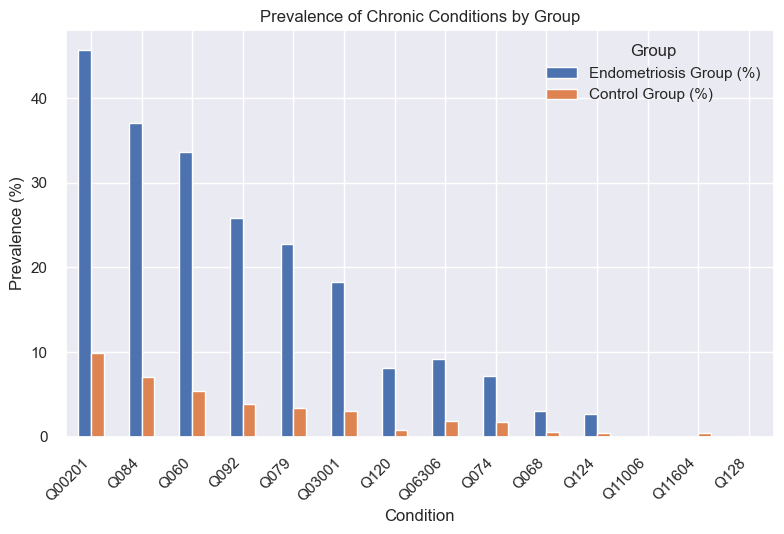

In [43]:
# Create a summary DataFrame for condition presence
endometriosis_conditions = pd.DataFrame()
control_conditions = pd.DataFrame()

# Calculate percentages for each condition
for condition in chronic_conditions:
    if condition in df.columns:
        endometriosis_conditions[condition] = df[has_endometriosis][condition].value_counts()
        control_conditions[condition] = df[~has_endometriosis][condition].value_counts()
        # Only drop '<None>' if it exists in the value counts
        if '<None>' in endometriosis_conditions[condition].index:
            endometriosis_conditions[condition] = endometriosis_conditions[condition].drop('<None>')
        if '<None>' in control_conditions[condition].index:
            control_conditions[condition] = control_conditions[condition].drop('<None>')

# Convert to percentages
for column in endometriosis_conditions.columns:
    endometriosis_conditions[column] = (endometriosis_conditions[column] / endometriosis_conditions[column].sum()) * 100

# Convert to percentages
for column in control_conditions.columns:
    control_conditions[column] = (control_conditions[column] / control_conditions[column].sum()) * 100

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Endometriosis Group (%)': endometriosis_conditions.iloc[1],
    'Control Group (%)': control_conditions.iloc[1], 
    'Difference (%)': endometriosis_conditions.iloc[1] - control_conditions.iloc[1]
}).sort_values('Difference (%)', ascending=False)

print("\nPrevalence of Chronic Conditions:")
print(comparison_df)

# Create visualization
plt.figure(figsize=(12, 8))
comparison_df[['Endometriosis Group (%)', 'Control Group (%)']].plot(kind='bar')
plt.title('Prevalence of Chronic Conditions by Group')
plt.ylabel('Prevalence (%)')
plt.xlabel('Condition')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Group')
plt.tight_layout()
plt.show()


Correlation Analysis:

Top Correlations with Endometriosis:
            C008  R010      R012      R025  R028    W00101    W00102  \
C008    1.000000   NaN  0.548874  0.064146   NaN -0.054142 -0.059651   
R010         NaN   NaN       NaN       NaN   NaN       NaN       NaN   
R012    0.548874   NaN  1.000000  0.041966   NaN -0.008674 -0.009284   
R025    0.064146   NaN  0.041966  1.000000   NaN  0.029514  0.029650   
R028         NaN   NaN       NaN       NaN   NaN       NaN       NaN   
W00101 -0.054142   NaN -0.008674  0.029514   NaN  1.000000  0.974796   
W00102 -0.059651   NaN -0.009284  0.029650   NaN  0.974796  1.000000   
W00103 -0.057542   NaN -0.023304  0.015787   NaN  0.941087  0.941313   
W00201 -0.057552   NaN -0.002656  0.042611   NaN  0.960814  0.960489   
W00202 -0.049290   NaN  0.001456  0.044385   NaN  0.952102  0.951818   

          W00103    W00201    W00202  ...    P00403    P00404    P00901  \
C008   -0.057542 -0.057552 -0.049290  ... -0.206309 -0.127019  0.076380

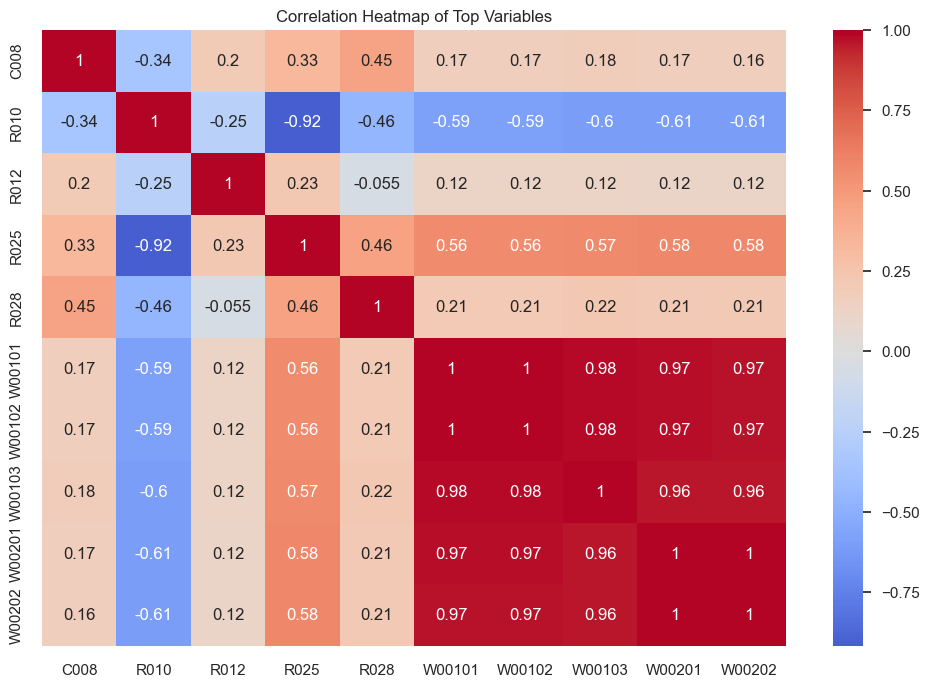

In [45]:
# Calculate correlations between endometriosis and other variables
print("\nCorrelation Analysis:")
# Select numeric variables for correlation analysis
numeric_vars = df.select_dtypes(include=[int, float]).columns
correlation_data = df[has_endometriosis][numeric_vars].corr()

# Print top correlations
print("\nTop Correlations with Endometriosis:")
print(correlation_data.head(10))
print("\nBottom Correlations with Endometriosis:")
print(correlation_data.tail(10))

# Create correlation heatmap for top variables
plt.figure(figsize=(12, 8))
top_vars = correlation_data.index[:10]
sns.heatmap(df[top_vars].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Top Variables')
plt.show()

In [46]:
# Year-wise comparison
print("\nYear-wise Comparison:")
year_comparison = df.groupby('V0020')['Q12201'].value_counts(normalize=True).unstack()
print(year_comparison)


Year-wise Comparison:
Q12201        00        01        02        04        05        06        08  \
V0020                                                                          
2019    0.000097  0.000028  0.000021  0.000007  0.000021  0.000014  0.000014   

Q12201        10        12        14  ...        81        82        83  \
V0020                                 ...                                 
2019    0.000007  0.000007  0.000007  ...  0.000014  0.000007  0.000007   

Q12201        84        85        87        89        90        94    <None>  
V0020                                                                         
2019    0.000021  0.000021  0.000007  0.000007  0.000028  0.000007  0.991183  

[1 rows x 86 columns]


In [29]:
df_uterus = None
df_corr = None

df_uterus = df[df['R010'].isin([1, 0])]

# Create correlation matrix for selected variables
categorical_vars = ['R011'] # 'C009'
boolean_vars = [
    "R010", "C008", "P050", "P027", "R028", "Q00201", "Q03001", 
    "Q060", "Q06306", "Q068", "Q074", "Q079", "Q084", "Q092", "Q11604",
    "Q120", "Q124"
]
selected_vars = categorical_vars + boolean_vars

# Create a copy of the data for correlation analysis
df_corr = df_uterus[selected_vars].copy()

# Create dummy variables for remaining categorical variables
df_corr = pd.get_dummies(df_corr, columns=categorical_vars)
for col in df_corr.columns:
    for var in categorical_vars:
        if var in col:
            df_corr[col] = df_corr[col].astype(int)

for col in df_corr.columns:
    if df_corr[col].dtype != 'int64':
        df_corr[col] = df_corr[col].fillna(0).astype(int)

df_corr

,R010,C008,P050,P027,R028,Q00201,Q03001,Q060,Q06306,Q068,...,Q120,Q124,R011_1,R011_2,R011_3,R011_4,R011_5,R011_6,R011_7,R011_<None>
4,0,32,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,27,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,28,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0,36,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
16,0,55,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251236,0,48,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
251237,0,51,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
251241,0,26,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
251244,0,54,1,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


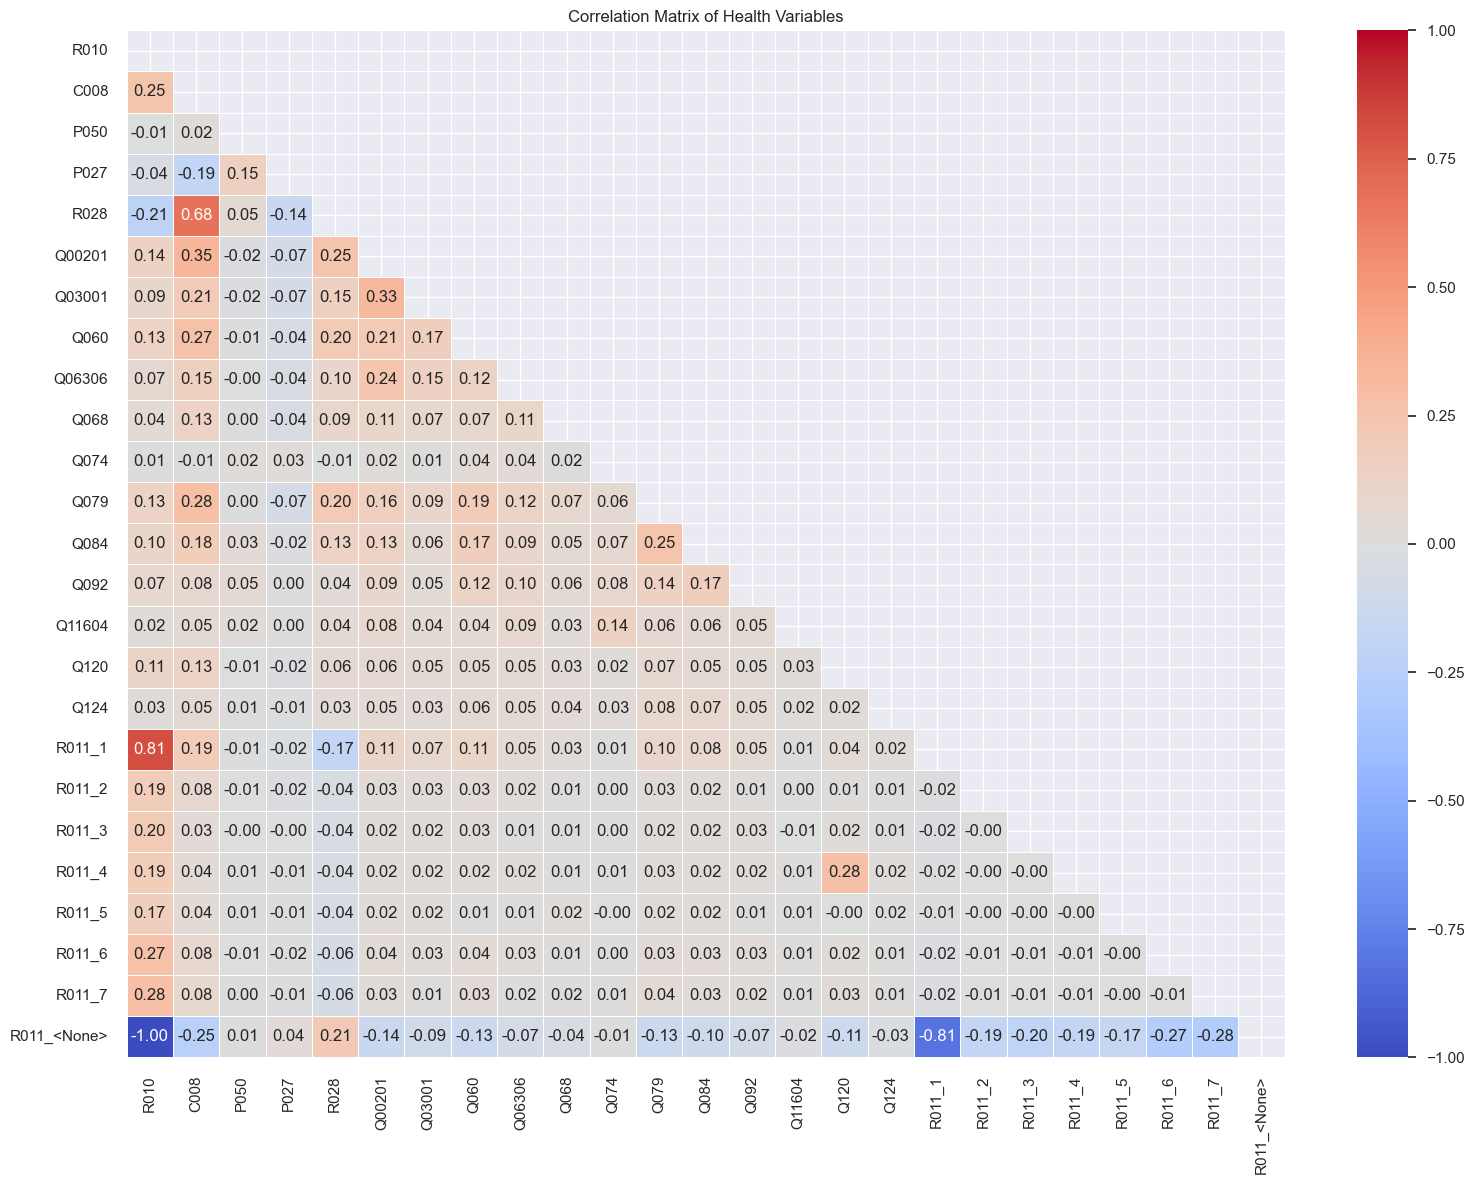


Strongest correlations (|correlation| > 0.3):
     var1         var2  correlation
1    R010  R011_<None>    -1.000000
5  R011_1  R011_<None>    -0.814162
0    R010       R011_1     0.814162
2    C008         R028     0.678736
3    C008       Q00201     0.347439
4  Q00201       Q03001     0.326966


In [30]:
# Calculate correlation matrix
corr_matrix = df_corr.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(16, 12))

# Create heatmap
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            center=0,
            fmt='.2f',
            # square=True,
            linewidths=.5)

plt.title('Correlation Matrix of Health Variables')
plt.tight_layout()
plt.show()

# Print strongest correlations (absolute value > 0.3)
print("\nStrongest correlations (|correlation| > 0.3):")
correlations = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i,j]) > 0.3:
            correlations.append({
                'var1': corr_matrix.columns[i],
                'var2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i,j]
            })

correlations_df = pd.DataFrame(correlations)
correlations_df = correlations_df.sort_values('correlation', key=abs, ascending=False)
print(correlations_df)


In [ ]:
print("\nDistinct values for each selected variable:")
for col in df_corr.columns:
    print(f"\n{col}:")
    print(df_corr[col].value_counts().sort_index())



# R010 - Categorical - Change to binary
# C008 - Numeric - No change
# C009 - Categorical - One hot encoding
# P050 - Categorical - if 1 or 2, change to 1, else 0
# P027 - Categorical - if 1 or 2, change to 1, else 0
# R028 - Categorical - One hot encoding
# Q00201 - Categorical - Change to binary
# Q03001 - Categorical - Change to binary
# Q060 - Categorical - Change to binary
# Q06306 - Categorical - Change to binary
# Q068 - Categorical - Change to binary
# Q074 - Categorical - Change to binary
# Q079 - Categorical - Change to binary
# Q084 - Categorical - Change to binary
# Q092 - Categorical - Change to binary
# Q11604 - Categorical - Change to binary
# Q120 - Categorical - Change to binary
# Q124 - Categorical - Change to binary



In [53]:
df_uterus = None
df_processed= None

df_processed = df[df['R010'].isin([1, 0])]

categorical_vars = []
target_vars = ['R011']
boolean_vars = [
    "R010", "C008", "P050", "P027", "R028", "Q00201", "Q03001", 
    "Q060", "Q06306", "Q068", "Q074", "Q079", "Q084", "Q092", "Q11604",
    "Q120", "Q124"
]
selected_vars = categorical_vars + boolean_vars + target_vars

# Create a copy of the data for correlation analysis
df_processed = df_processed[selected_vars].copy()

# Create dummy variables for remaining categorical variables
df_processed = pd.get_dummies(df_processed, columns=categorical_vars)
for col in df_processed.columns:
    for var in categorical_vars:
        if var in col:
            df_processed[col] = df_processed[col].astype(int)

for col in boolean_vars:
    if df_processed[col].dtype != 'int64':
        df_processed[col] = df_processed[col].fillna(0).astype(int)

# Transform R011, endometriosis indicator, to binary
df_processed['R011'] = df_processed['R011'].apply(lambda x: 1 if x == '3' else 0)

df_processed

,R010,C008,P050,P027,R028,Q00201,Q03001,Q060,Q06306,Q068,Q074,Q079,Q084,Q092,Q11604,Q120,Q124,R011
4,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16,0,55,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251236,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
251237,0,51,0,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0
251241,0,26,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
251244,0,54,1,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0


In [54]:
# Save processed data for modeling
df_processed.to_parquet("..\data\processed\PNS_processed.parquet", index=False)